In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))
        self.v_bias = nn.Parameter(torch.zeros(num_visible))

    def forward(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        h_sample = torch.bernoulli(h_prob)
        return h_sample, h_prob

    def backward(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        v_sample = torch.bernoulli(v_prob)
        return v_sample, v_prob


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.flatten(x)),
                                transforms.Lambda(lambda x: torch.bernoulli(x))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [4]:
num_visible = 28 * 28
num_hidden = 500
num_epochs = 60
lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the RBM model to the device
rbm = RBM(num_visible, num_hidden).to(device)

optimizer = optim.SGD(rbm.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    for i, (data, _) in enumerate(train_loader):
        data = data.view(-1, num_visible).to(device)
        h0_sample, h0_prob = rbm(data)
        v1_sample, v1_prob = rbm.backward(h0_sample)
        h1_sample, h1_prob = rbm(v1_sample)

        loss = torch.mean(data * torch.log(v1_prob) + (1 - data) * torch.log(1 - v1_prob))

        optimizer.zero_grad()
        positive_grad = torch.matmul(h0_prob.t(), data)
        negative_grad = torch.matmul(h1_prob.t(), v1_sample)
        loss.backward()
        optimizer.step()

        rbm.W.data += lr * (positive_grad - negative_grad) / data.size(0)

    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")


Epoch: 1, Loss: -0.2150
Epoch: 2, Loss: -0.1747
Epoch: 3, Loss: -0.1675
Epoch: 4, Loss: -0.1499
Epoch: 5, Loss: -0.1367
Epoch: 6, Loss: -0.1427
Epoch: 7, Loss: -0.1309
Epoch: 8, Loss: -0.1295
Epoch: 9, Loss: -0.1165
Epoch: 10, Loss: -0.1289
Epoch: 11, Loss: -0.1266
Epoch: 12, Loss: -0.1210
Epoch: 13, Loss: -0.1167
Epoch: 14, Loss: -0.1137
Epoch: 15, Loss: -0.1128
Epoch: 16, Loss: -0.1100
Epoch: 17, Loss: -0.1099
Epoch: 18, Loss: -0.1083
Epoch: 19, Loss: -0.1142
Epoch: 20, Loss: -0.1047
Epoch: 21, Loss: -0.1080
Epoch: 22, Loss: -0.1065
Epoch: 23, Loss: -0.1019
Epoch: 24, Loss: -0.1021
Epoch: 25, Loss: -0.0993
Epoch: 26, Loss: -0.1020
Epoch: 27, Loss: -0.0981
Epoch: 28, Loss: -0.1029
Epoch: 29, Loss: -0.1020
Epoch: 30, Loss: -0.0976
Epoch: 31, Loss: -0.0957
Epoch: 32, Loss: -0.0962
Epoch: 33, Loss: -0.0960
Epoch: 34, Loss: -0.0950
Epoch: 35, Loss: -0.0956
Epoch: 36, Loss: -0.0973
Epoch: 37, Loss: -0.0927
Epoch: 38, Loss: -0.0927
Epoch: 39, Loss: -0.0912
Epoch: 40, Loss: -0.0970
Epoch: 41

In [5]:
def gibbs_sampling(rbm, num_gibbs_steps=100, num_samples=16):
    h = torch.bernoulli(0.5 * torch.ones(num_samples, num_hidden).to(device))
    for _ in range(num_gibbs_steps):
        v, _ = rbm.backward(h)
        h, _ = rbm(v)
    return v

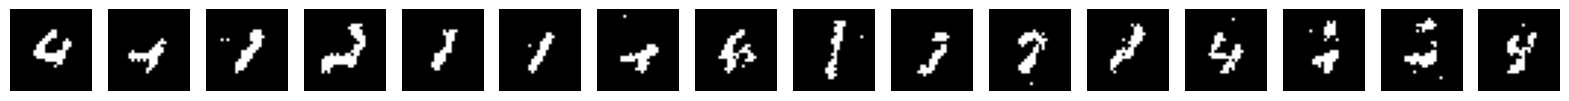

In [6]:
# Generate samples after training
with torch.no_grad():
    samples = gibbs_sampling(rbm).cpu().view(-1, 28, 28).numpy()

# Visualization code (you'll need to import matplotlib)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(samples), figsize=(20, 20))
for axis, sample in zip(axes, samples):
    axis.imshow(sample, cmap="gray")
    axis.axis("off")
plt.show()